In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pink_utils as pu
import astropy.units as u
from tqdm import tqdm
from astropy.coordinates import SkyCoord
import sklearn.neighbors as skn


In [2]:
FIRST_PIX = 1.8*u.arcsecond # Pixel size of FIRST survey. Square pixels
FIRST_FWHM = 5*u.arcsecond / FIRST_PIX
FIRST_SIG = FIRST_FWHM / 2.355

# Load the Required items in
df        = pd.read_csv('../Experiment/Experiment_F3W2_95_5/FIRST_Cata_Images.csv')
transform = pu.transform('../Experiment/Experiment_F3W2_95_5/F3W2_95_5_Transform_Matrix.bin')
ed        = pu.heatmap('../Experiment/Experiment_F3W2_95_5/F3W2_95_5_ED_Matrix.bin')
som       = pu.som('../Experiment/Experiment_F3W2_95_5/Results/F3W2_95_5/F3W2S_95_5_6.bin')
images    = pu.image_binary('../Experiment/Experiment_F3W2_95_5/Results/F3W2_95_5.bin')

/Users/gal16b/miniconda3/envs/pink_e3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3018: DtypeWarning: Columns (73,74) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
print(som.file_head)
NEURON_SIZE = som.file_head[-1] # Equal dimensions 

(2, 15, 15, 1, 118, 118)


In [4]:
def return_transform(index, pos_min):
    rot = transform.transform(index=index).reshape(transform.header_info[1:])
    flip, ro = rot[pos_min[1], pos_min[0]][0]    

    return flip, ro

def return_bmu(index):
    hmap = ed.ed(index=index)
    pos_min = np.unravel_index(np.argmin(hmap), hmap.shape)

    return pos_min

In [7]:
flip  = []
angle = []
bmux  = []
bmuy  = []
idx   = [] 
max_src = 50000

for (index, row) in tqdm(df.iterrows()):
    if index == max_src:
        break
    
    idx.append(index)

    # Get rotation information
    # ---------------------------------------------------------
    bmu_pos = return_bmu(index)
    rotation = return_transform(index, bmu_pos)
    # ---------------------------------------------------------
    
    flip.append(rotation[0])
    angle.append(rotation[1])
    bmux.append(bmu_pos[0])
    bmuy.append(bmu_pos[1])

50000it [00:03, 16298.25it/s]


In [8]:
df = df.iloc[idx]
df.loc[idx, 'flip'] = flip
df.loc[idx, 'angle'] = angle
df.loc[idx, 'bmux'] = bmux
df.loc[idx, 'bmuy'] = bmuy

In [9]:
#Packing positions up for the BallTree
ra = np.deg2rad(df['radio.ra'])
dec = np.deg2rad(df['radio.dec'])
points = np.array((ra, dec)).T

# Create angular separation method consistent with the astropy .separation()
def sep(a, b):
    """ Code modified from astropy.coordinates.angle_utils.angular_separation
    """
    sdlon = np.sin(b[0] - a[0])
    cdlon = np.cos(b[0] - a[0])
    slat1 = np.sin(a[1])
    slat2 = np.sin(b[1])
    clat1 = np.cos(a[1])
    clat2 = np.cos(b[1])
    
    num1 = clat2 * sdlon
    num2 = clat1 * slat2 - slat1 * clat2 * cdlon
    denominator = slat1 * slat2 + clat1 * clat2 * cdlon

    return np.arctan2(np.hypot(num1, num2), denominator)

In [10]:
kdtree = skn.BallTree(points, metric='pyfunc', func=sep)

In [11]:
ra1, dec1 = points[0]

print(ra1, dec1)

3.602540425318245 0.40805647312751325


In [12]:
dist, indices = kdtree.query(np.array((ra1, dec1)).reshape((1,-1)), k=3)
dist, indices

(array([[0.        , 0.00019161, 0.00191697]]), array([[  0,   1, 212]]))

In [13]:
dist*u.deg.to(u.arcsecond)

array([[0.        , 0.68979768, 6.90110756]])

In [73]:
def pos_offset(a, b):
    a_pos = SkyCoord(ra=a[0]*u.radian, dec=a[1]*u.radian, frame='icrs')
    b_pos = SkyCoord(ra=b[0]*u.radian, dec=b[1]*u.radian, frame='icrs')
    
    return a_pos.spherical_offsets_to(b_pos), a_pos.separation(b_pos)

0d00m00s
13 8
0d00m39.5225s
4 4
0d06m35.4043s
1 9


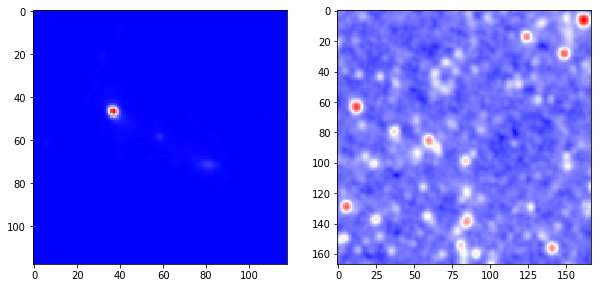

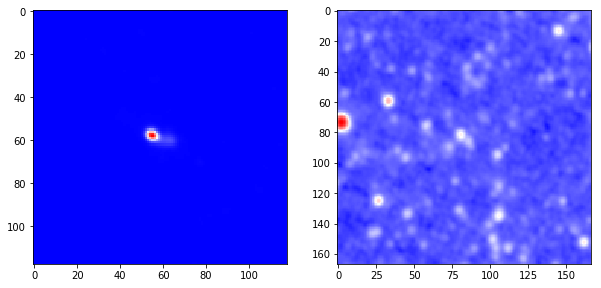

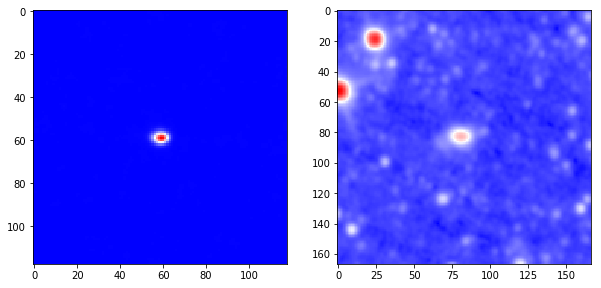

In [94]:
imgs = []
offs = []
for i in indices[0]:
    ra2, dec2 = points[i]    
    offsets, sep = pos_offset((ra1, dec1), (ra2, dec2))
    print(sep)
    print(df.loc[i, 'bmux'], df.loc[i, 'bmuy'])
    
    dx = (offsets[0]/FIRST_PIX).decompose()
    dy = (offsets[1]/FIRST_PIX).decompose()
    offs.append((dy, -dx))
    
    imgs.append(np.sqrt(images.get_image(index=i, channel=1)))
    
    fig, (ax2, ax3) = plt.subplots(1,2, figsize=(10,5))
    
    ax2.imshow(som.get_neuron(x=df.loc[i, 'bmux'], y=df.loc[i, 'bmuy']), cmap='bwr')
    ax3.imshow(np.sqrt(images.get_image(index=i, channel=1)), cmap='bwr')
    
    fig.show()

In [98]:
def combine_img(cen_img, img, offset):
    # offset is relative to center pixel of cen_img
    # Dimensions are same as the shape - (y, x)
    cen_y, cen_x = np.array(cen_img.shape) // 2
    print(cen_img.shape)
    
    ny = int(cen_img.shape[0] + 2*np.abs(offset[0]) + 0.5)
    nx = int(cen_img.shape[1] + 2*np.abs(offset[1]) + 0.5)

    cen_img_zeros = np.zeros((ny, nx))
    img_zeros = np.zeros((ny, nx))
    
    slice_y = int(np.abs(offset[0]) + 0.5)
    slice_x = int(np.abs(offset[1]) + 0.5)

    cen_img_zeros[slice_y:slice_y+cen_img.shape[0],
                  slice_x:slice_x+cen_img.shape[1]] = cen_img[:,:]
    
    slice_y += int(offset[0])
    slice_x += int(offset[1])
    
    img_zeros[slice_y:slice_y+img.shape[0],
              slice_x:slice_x+img.shape[1]] = img[:,:]
    
    combine = np.sum(np.array((cen_img_zeros, img_zeros)),axis=0)/2
    
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(10,4))
    
    ax1.imshow(np.sqrt(cen_img_zeros), cmap='bwr')
    ax2.imshow(np.sqrt(img_zeros), cmap='bwr')
    ax3.imshow(np.sqrt(combine), cmap='bwr')
    
    fig.show()
    
    print(combine.shape)
    return combine

(167, 167)
(175, 210)


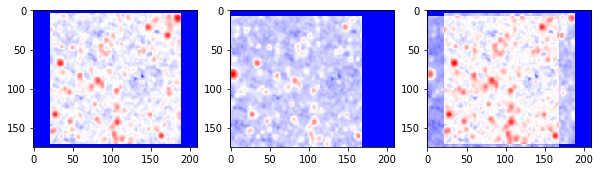

In [99]:
a = combine_img(imgs[0], imgs[1], offs[1])

(175, 210)
(428, 569)


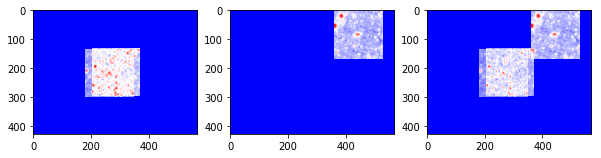

In [100]:
b = combine_img(a, imgs[2], offs[2])